# Imports

In [75]:
import matplotlib.pyplot as plt
import numpy as np
import warnings

from sklearn.exceptions import ConvergenceWarning
from sklearn.datasets import make_moons, make_blobs
from sklearn.cluster import Birch
from sklearn.metrics import (
            make_scorer,
            v_measure_score,
            homogeneity_score,
            completeness_score,
            jaccard_score
        )
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample
from time import time
from tqdm.notebook import tqdm
from scipy.optimize import linear_sum_assignment

RAND_SEED = 0

## Methods

In [78]:
def visualize_data(X, y):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=25, cmap='viridis')
    plt.show()


def baseline_clustering(X, X_big):
    """
    Applies a default BIRCH clustering to the data, serving as a reference point for comparing the
    performance of other clustering methods.
    """
    # Perform BIRCH clustering on X
    start_time = time()
    birch = Birch(n_clusters=None)
    birch.fit(X)
    labels = birch.predict(X)
    clustering_time = time() - start_time

    # Perform BIRCH clustering on X_big
    start_time_big = time()
    birch_big = Birch(n_clusters=None)
    birch_big.fit(X_big)
    labels_big = birch_big.predict(X_big)
    clustering_time_big = time() - start_time_big

    # Plot the clusters
    plt.scatter(X[:, 0], X[:, 1], c=labels, s=25, cmap='viridis')
    plt.title('Clusters determined by BIRCH')
    plt.text(0.05, 0.05, f'Number of clusters: {len(set(labels))}', transform=plt.gca().transAxes)
    plt.show()
    
    return labels, birch, labels_big, birch_big, clustering_time, clustering_time_big


def print_time(clustering_time, clustering_time_big):
    print(f"Clustering time for X: {clustering_time} seconds")
    print(f"Clustering time for X_big: {clustering_time_big} seconds")


def find_best_birch_params(X, real_labels, reduced_param_quant=False, n_clusters=None):
    """
    Performs a grid search to find the optimal parameters for the Birch clustering algorithm on a given dataset.
    """
    if not reduced_param_quant:
        parameters = {
            'threshold': np.arange(0.05, 0.95, 0.05),
            'branching_factor': np.arange(5, 60, 5),
            'n_clusters': [None, 2, 3, 4, 5, 6] if not n_clusters else [n_clusters]
        }
    else:
        parameters = {
            'threshold': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
            'branching_factor': [5, 10, 15, 20],
            'n_clusters': [None, 2, 3, 4, 5, 6] if not n_clusters else [n_clusters]
        }

    scoring = {
        'Homogeneity': make_scorer(homogeneity_score),
        'Completeness': make_scorer(completeness_score),
        'V-measure': make_scorer(v_measure_score)
    }

    fig = plt.figure(figsize=(6, 18))
    grid_search_arr = []
    
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        for i, metric in tqdm(enumerate(scoring, start=1), total=len(scoring)):
            print(f"Optimizing for {metric}")
            birch = Birch()
            grid_search = GridSearchCV(birch, parameters, scoring=scoring, refit=metric)
            grid_search.fit(X, real_labels)
            grid_search_arr.append(grid_search)
            
            best_params = grid_search.best_params_
            best_score = grid_search.best_score_
            print(f"Best parameters: {best_params}")
            print(f"Best score: {np.clip(best_score, 0, 1)}")

            # Plot the clusters for the best model
            ax = fig.add_subplot(len(scoring), 1, i)
            labels = grid_search.predict(X)
            ax.scatter(X[:, 0], X[:, 1], c=labels, s=25, cmap='viridis')
            ax.set_title(f'Clusters determined by BIRCH ({metric})')

            # Display all metrics
            y_position = 0.2
            plt.text(0.05, 0.05, f'Number of clusters: {len(set(labels))}', transform=plt.gca().transAxes)
            for score_name, scorer in scoring.items():
                if score_name == metric:
                    ax.text(0.05, y_position, f'{score_name}: {grid_search.cv_results_["mean_test_" + score_name][grid_search.best_index_]:.2f} (best)', transform=ax.transAxes, weight='bold')
                else:
                    ax.text(0.05, y_position, f'{score_name}: {grid_search.cv_results_["mean_test_" + score_name][grid_search.best_index_]:.2f}', transform=ax.transAxes)
                y_position -= 0.05

    plt.tight_layout()
    plt.show()

    return grid_search_arr


def check_stability(grid_searches, X, num_subsamples=10):
    """
    Evaluates the stability of clustering algorithm (in this case specific hyperparameters for BIRCH) using
    the Jaccard index and resampling.
    """
    # Function to match cluster labels
    def match_cluster_labels(labels1, labels2):
        cost_matrix = -np.array([[np.sum(labels1 == i & (labels2 == j)) for j in np.unique(labels2)] for i in np.unique(labels1)])
        row_ind, col_ind = linear_sum_assignment(cost_matrix)
        return row_ind, col_ind
    
    # Create subsamples
    subsamples = [resample(X, replace=True, random_state=RAND_SEED + i) for i in range(num_subsamples)]

    # Initialize list to store mean Jaccard scores for each GridSearchCV
    mean_jaccard_scores = []

    # For each GridSearchCV, get the best parameters and apply clustering to each subsample
    for grid_search in grid_searches:
        best_params = grid_search.best_params_
        birch = Birch(**best_params)
        
        # Apply clustering to each subsample
        cluster_labels = [birch.fit_predict(subsample) for subsample in subsamples]

        # Compute Jaccard index for pairwise cluster agreement
        jaccard_scores = []
        for i in range(num_subsamples):
            for j in range(i + 1, num_subsamples):
                jaccard_scores.append(jaccard_score(*match_cluster_labels(cluster_labels[i], cluster_labels[j]), average='macro'))

        # Calculate stability metric (e.g., mean Jaccard index)
        mean_jaccard = np.mean(jaccard_scores)
        mean_jaccard_scores.append(mean_jaccard)

    # Print mean Jaccard scores for each GridSearchCV
    for i, score in enumerate(mean_jaccard_scores):
        print(f"GridSearchCV {i+1}: {score}")

## BIRCH
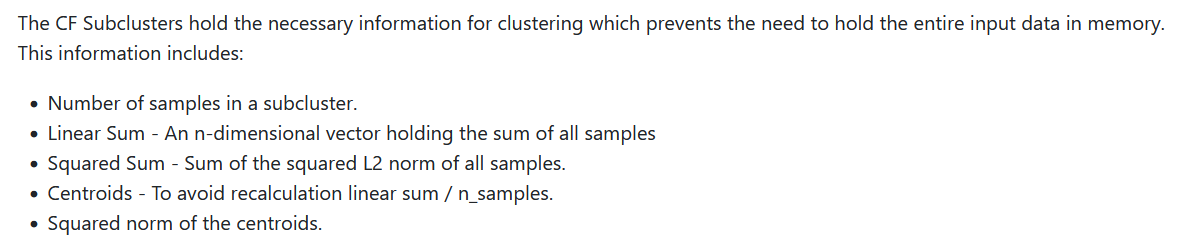
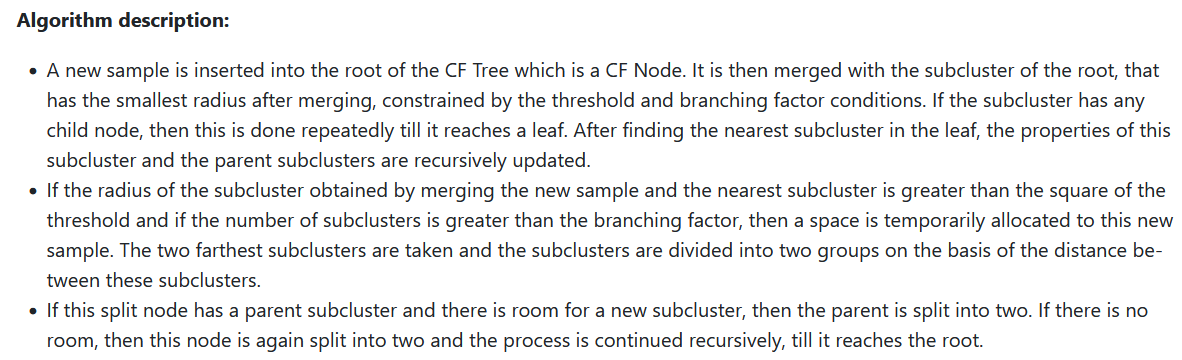
## Metrics
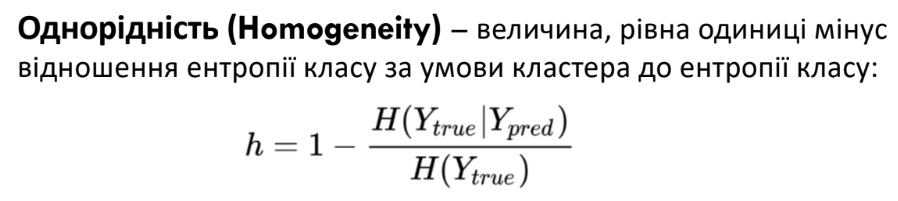
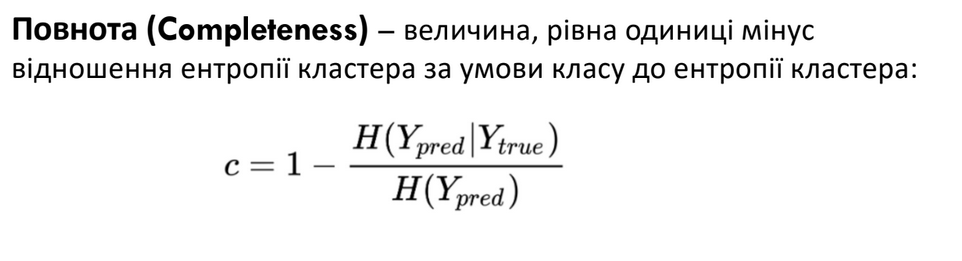
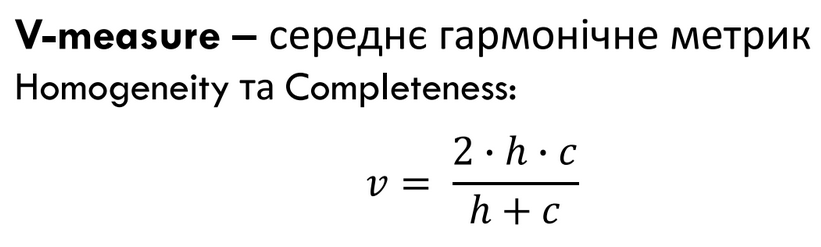

# Experiments for "moons" dataset

##### Creating data

In [33]:
make_moons_func = lambda n_samples: make_moons(
    n_samples=n_samples,
    noise=0.05,
    random_state=RAND_SEED
)

X_moons, y_moons = make_moons_func(500)
X_moons_big, y_moons_big = make_moons_func(1000000) # 1 million samples

##### Visualization

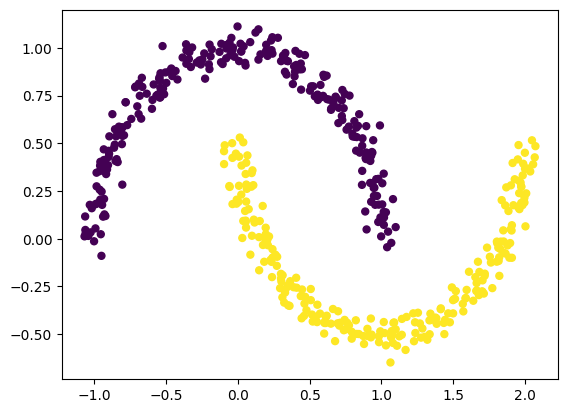

In [34]:
visualize_data(X_moons, y_moons)

##### Clustering with default parameters

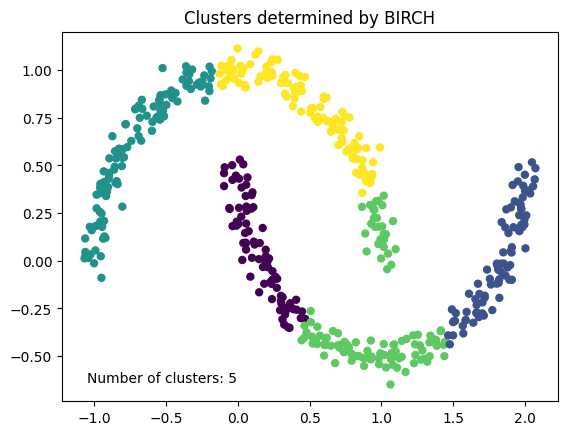

In [84]:
labels_moon_bsl, brc_moon_bsl, _, _, moon_time, moon_time_big = baseline_clustering(X_moons, X_moons_big)

As we can see BIRCH automatically separated data into 5 clusters, which is not correct.
##### Comparing clustering time for small and big sets

In [85]:
print_time(moon_time, moon_time_big)

Clustering time for X: 0.014000415802001953 seconds
Clustering time for X_big: 12.419350147247314 seconds


As we can see the clustering time for the big dataset is much larger than for the small one. However, the bigger dataset contains 1 million samples, so this time result is very good.

##### GridSearchCV for the best hyperparameters using different metrics as the main ones

  0%|          | 0/3 [00:00<?, ?it/s]

Optimizing for Homogeneity
Best parameters: {'branching_factor': 10, 'n_clusters': None, 'threshold': 0.25}
Best score: 1.0
Optimizing for Completeness
Best parameters: {'branching_factor': 15, 'n_clusters': 2, 'threshold': 0.1}
Best score: 0.5267617673065009
Optimizing for V-measure
Best parameters: {'branching_factor': 15, 'n_clusters': 5, 'threshold': 0.15000000000000002}
Best score: 0.6192552583297642


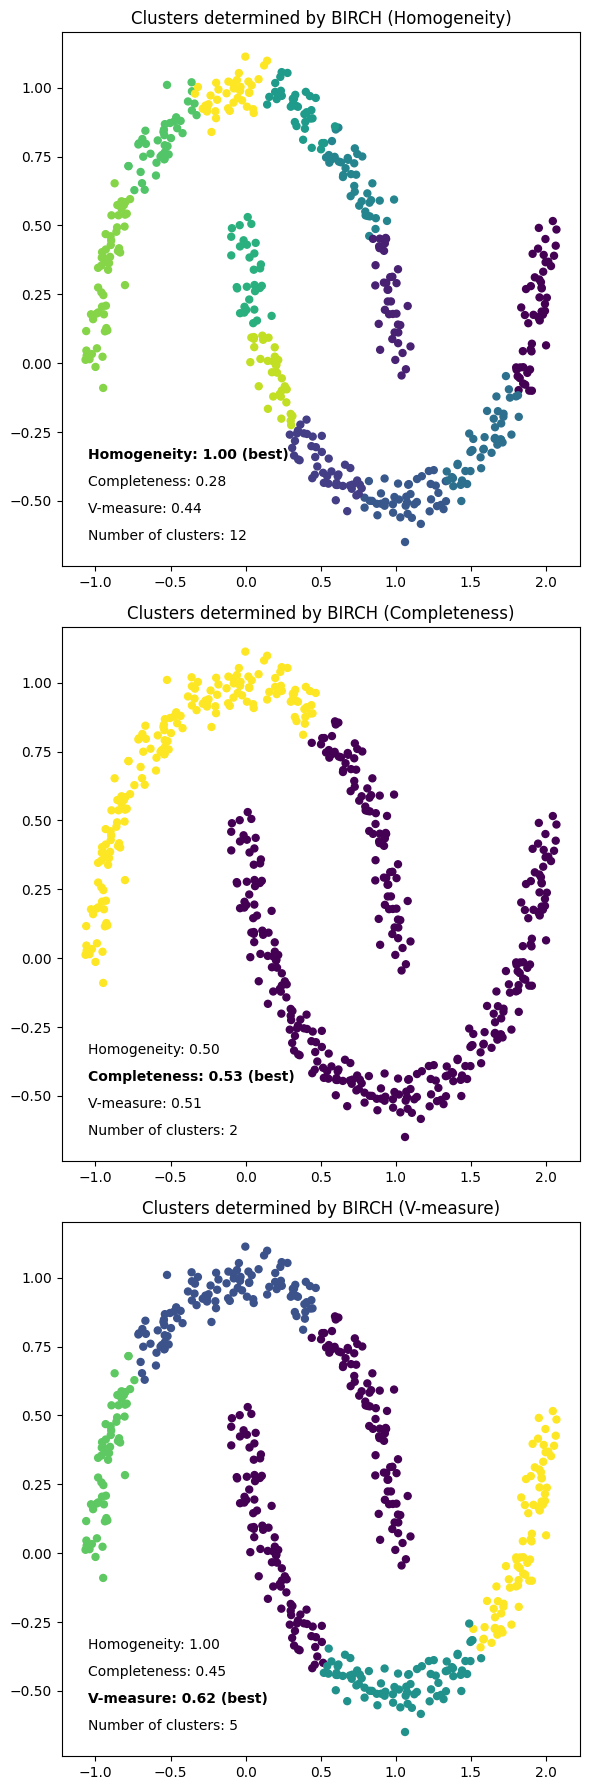

In [61]:
grid_search_arr_moons = find_best_birch_params(X_moons, y_moons)

In [80]:
check_stability(grid_search_arr_moons, X_moons)

GridSearchCV 1: 0.17740222740222739
GridSearchCV 2: 0.8
GridSearchCV 3: 0.43555555555555553


<b> Conclusions: </b>As we can see, when using Completeness as the optimized metric, BIRCH is able to identify 2 clusters as the best quantity using GridSearchCV. We also get the best stability for the two clusters and best hyperparameters, chosen by GridSearchCV. However, BIRCH still clusterizes part of the samples from the yellow moon incorrectly.

# Experiments for "blobs" dataset

##### Creating data

In [62]:
def make_blobs_func(n_samples):
    X1, y_blobs = make_blobs(
        n_samples=n_samples,
        centers=4,
        cluster_std=0.60,
        random_state=RAND_SEED
    )

    rng = np.random.RandomState(13)
    X_blobs = np.dot(X1, rng.randn(2, 2))
    return X_blobs, y_blobs

X_blobs, y_blobs = make_blobs_func(10000)
X_blobs_big, y_blobs_big = make_blobs_func(1000000) # 1 million samples

##### Visualization

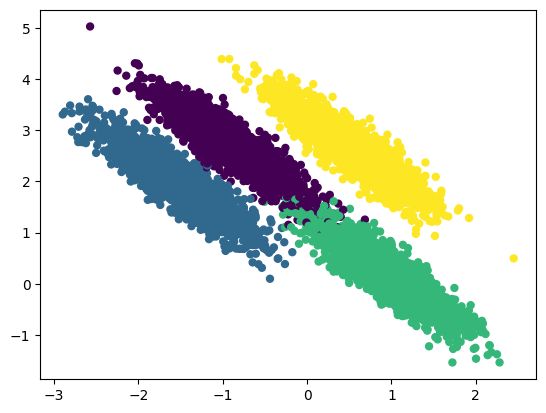

In [63]:
visualize_data(X_blobs, y_blobs)

##### Clustering with default parameters

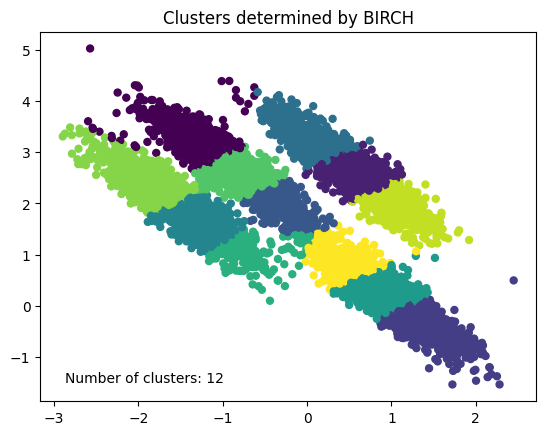

In [87]:
labels_blobs_bsl, brc_blobs_bsl, _, _, blobs_time, blobs_time_big = baseline_clustering(X_blobs, X_blobs_big)

As we can see BIRCH automatically separated data into 12 clusters, which is much more than 4.
##### Comparing clustering time for small and big sets

In [88]:
print_time(blobs_time, blobs_time_big)

Clustering time for X: 0.12599825859069824 seconds
Clustering time for X_big: 13.254866600036621 seconds


As we can see the clustering time for the big dataset is much larger than for the small one. However, the bigger dataset contains 1 million samples, so this time result is very good.

##### GridSearchCV for the best hyperparameters using different metrics as the main ones

  0%|          | 0/3 [00:00<?, ?it/s]

Optimizing for Homogeneity
Best parameters: {'branching_factor': 5, 'n_clusters': None, 'threshold': 0.05}
Best score: 0.9967599605331923
Optimizing for Completeness
Best parameters: {'branching_factor': 20, 'n_clusters': 2, 'threshold': 0.05}
Best score: 0.8635237960577349
Optimizing for V-measure
Best parameters: {'branching_factor': 5, 'n_clusters': 3, 'threshold': 0.05}
Best score: 0.7247669707867022


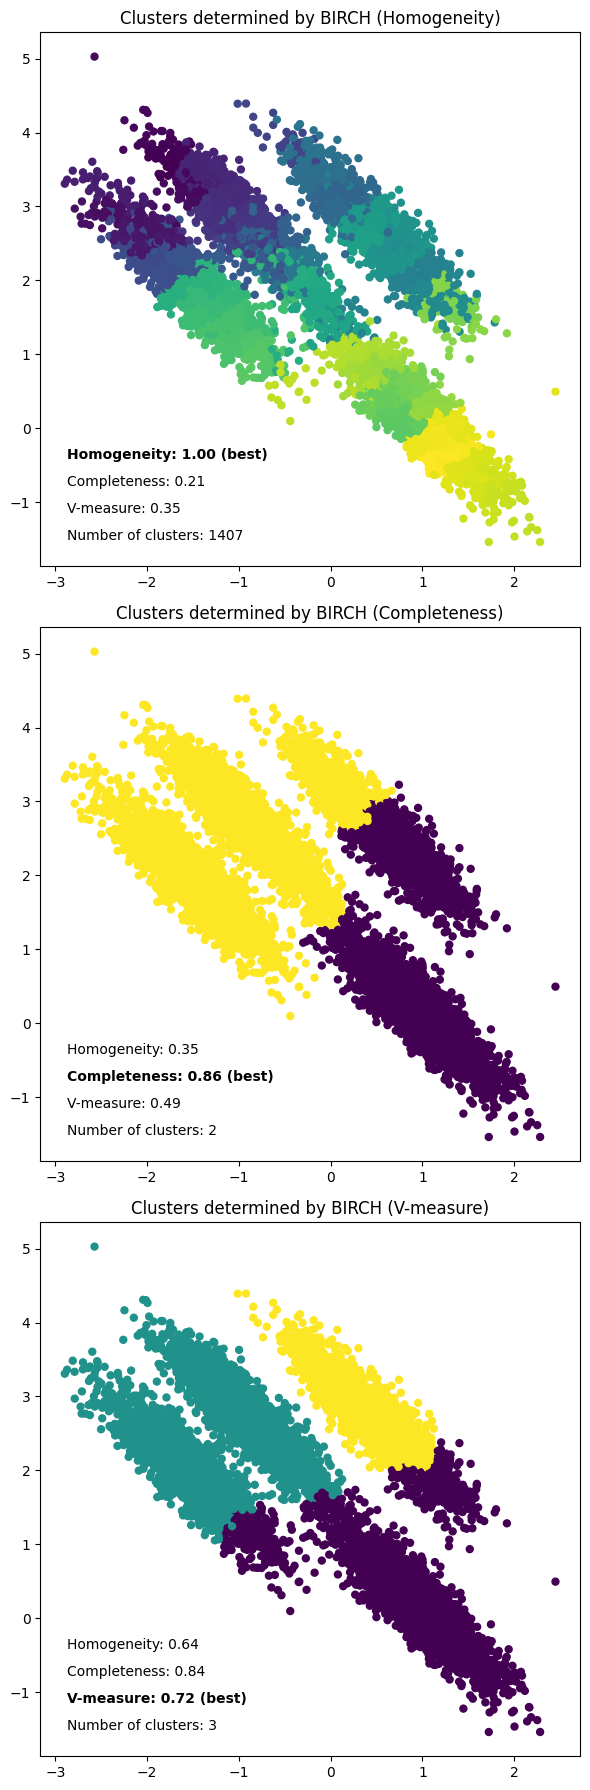

In [71]:
grid_search_arr_blobs = find_best_birch_params(X_blobs, y_blobs, reduced_param_quant=True)

As we can see, using Homogeneity as the optimized metric in the case of anisotropicly distributed data leads to enormous amount of clusters. The best option in this case is to chose V-measure as the optimized metric, although it still produces only 3 clusters instead of 4. For the sake of experiment, let's try strictly specifying number of clusters as 4.

  0%|          | 0/3 [00:00<?, ?it/s]

Optimizing for Homogeneity
Best parameters: {'branching_factor': 10, 'n_clusters': 4, 'threshold': 0.55}
Best score: 0.7250267715368882
Optimizing for Completeness
Best parameters: {'branching_factor': 5, 'n_clusters': 4, 'threshold': 0.6500000000000001}
Best score: 0.8093612166010304
Optimizing for V-measure
Best parameters: {'branching_factor': 5, 'n_clusters': 4, 'threshold': 0.6500000000000001}
Best score: 0.7536064142540554


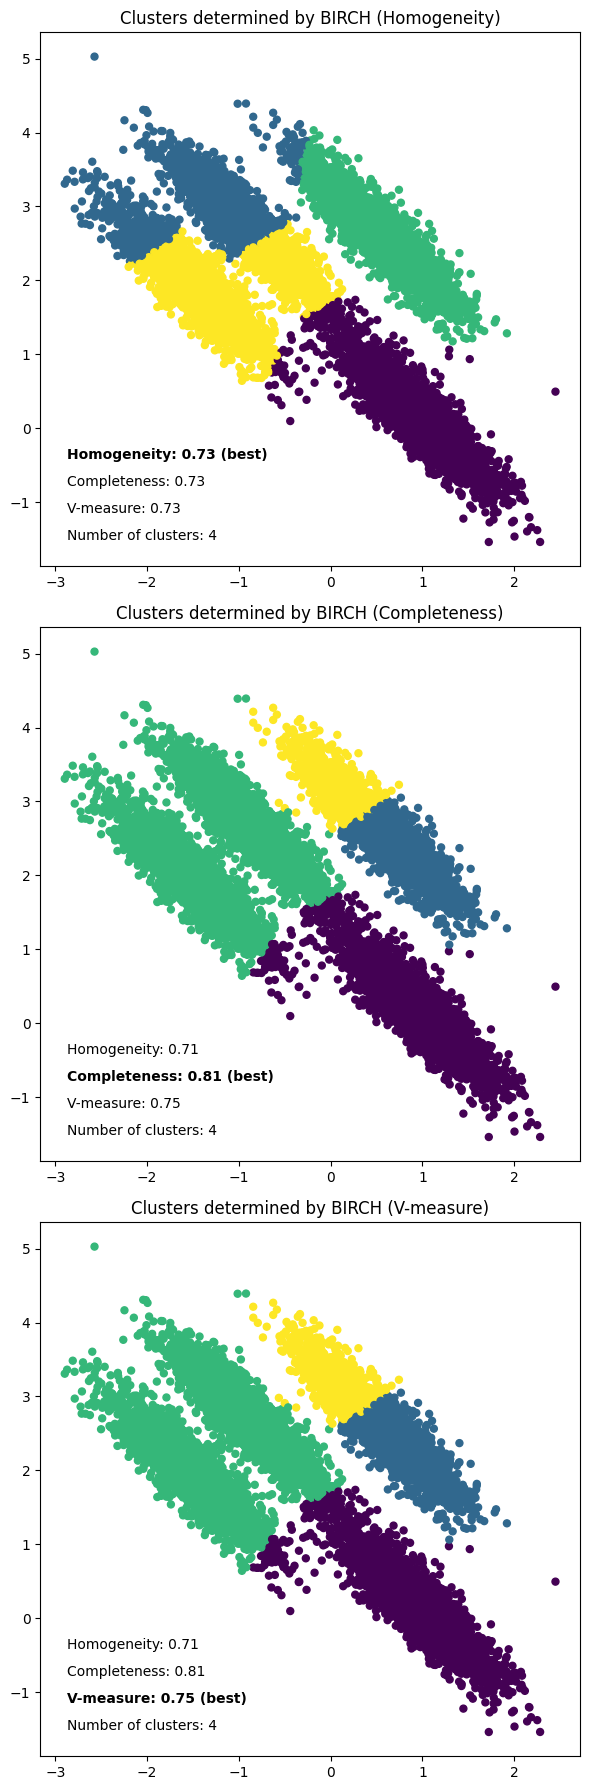

In [73]:
grid_search_arr_blobs_fixed = find_best_birch_params(X_blobs, y_blobs, n_clusters=4)

In [82]:
check_stability([grid_search_arr_blobs[1], grid_search_arr_blobs[2], grid_search_arr_blobs_fixed[0], grid_search_arr_blobs_fixed[1]], X_blobs)

GridSearchCV 1: 1.0
GridSearchCV 2: 0.5703703703703703
GridSearchCV 3: 0.37222222222222223
GridSearchCV 4: 0.39444444444444443


<b> Conclusions: </b>As we can see we still can't get satisfactory results. Interestingly that in this case we also get worse stability with the bigger amount of clusters, possibly due to the fact, that clusters are nonspherical, very close to each other and have a high degree of intersection. <br>
The main conclusion, is that BIRCH doesn't suit well for nonspherical or nonconvex data. However, it is good for low-dimensional large number of instances spherical (or globular) data.